# Theme Distilation

Experiments related to verbatim clustering and summarization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from fastai.text import *   # Quick accesss to NLP functionality
from fastai.callbacks import *

import pdb
from tritonlytics import Metrics as metrics_util, DataGeneration as dg_util, PandasUtil as pd_util
from tritonlytics.evaluation import *
from tritonlytics.callbacks import RocAucEvaluation

import dill as pickle

import spacy
spacy_en = spacy.load('en')
spacy_es = spacy.load('es')

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
print(f'fastai version: {__version__}')

fastai version: 1.0.52


In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Configuration

In [5]:
# various default, LM, and classification paths
PATH = Path('../data/thematization')

LM_PATH = Path('../data/sent_analysis/lm')
CLS_PATH = Path('../data/sent_analysis/class')

In [6]:
# dataframe config
verbatims_filename = 'verbatims-clean.csv'

# basic columns
col_dtypes = { 
    'AnswerText': str, 'AnswerText_NonEnglish': str, 'Language': str,
    
    'SurveyTypeID': int, 'BenchmarkSurveyType': str, 'ClientId': str,
    
    'QuestionReportAbbr': str, 'QuestionText': str, 'QuestionClass': str, 
    
    'QuestionCategoryID': float, 'QuestionCategoryAbbr': str, 'QuestionCategoryLabel': str, 
    'BenchmarkLevel1': str, 'BenchmarkLevel2': str, 'BenchmarkLevel3': str, 'ClientBenchmarkLevel': str,
    
    'GroupCode': float, 'GroupName': str, 
    'GroupLevel1Code': float, 'GroupLevel1Name': str, 'GroupLevel2Code': float, 'GroupLevel2Name': str, 
    'GroupLevel3Code': float, 'GroupLevel3Name': str, 'GroupLevel4Code': float, 'GroupLevel4Name': str,
    'GroupLevel5Code': float, 'GroupLevel5Name': str, 'GroupLevel6Code': float, 'GroupLevel6Name': str, 
    'GroupLevel7Code': float, 'GroupLevel7Name': str, 'GroupLevel8Code': float, 'GroupLevel8Name': str,
    
    'TagCount': int
}

# sentiment and entity labels
sent_dtypes = { 
    'OverallSentiment': int, 'IsVeryPositive': int, 'IsPositive': int, 'IsVeryNegative': int, 'IsNegative' : int, 
    'IsSuggestion' : int, 'FeelsThreatened' : int, 'HasProfanity' : int, 'IsNonsense' : int 
}

# date columns
date_cols = ['LastTaggedOn']

dtypes = {**col_dtypes, **sent_dtypes }


# string columns (that can be used in language modeling), labels and classes
TXT_COLS = [
    'AnswerText', 'AnswerText_NonEnglish', 'Language',
    'BenchmarkSurveyType', 'ClientId',
    'QuestionReportAbbr', 'QuestionText', 'QuestionClass', 
    'QuestionCategoryAbbr', 'QuestionCategoryLabel',
    'BenchmarkLevel1', 'BenchmarkLevel2', 'BenchmarkLevel3', 'ClientBenchmarkLevel',
    'GroupName', 
    'GroupLevel1Name', 'GroupLevel2Name', 'GroupLevel3Name', 'GroupLevel4Name', 
    'GroupLevel5Name', 'GroupLevel6Name', 'GroupLevel7Name', 'GroupLevel8Name'
]

LABELS_SENT = list(sent_dtypes.keys())
LABELS = LABELS_SENT

CLASSES = [['Very Negative', 'Negative', 'Neutral', 'Positive', 'VeryPositive'], ['no', 'yes']]

In [7]:
%%time 

final_df = pd.read_csv(CLS_PATH/f'all_predictions_20190522.csv', dtype=dtypes, parse_dates=date_cols)

doc_vecs = np.load(CLS_PATH/f'all_predictions_20190522_fwd_d400.npy')
concat_doc_vecs = np.load(CLS_PATH/f'all_predictions_20190522_fwd_d1200.npy')

# doc_vecs = np.load(CLS_PATH/f'all_predictions_20190110_bwd_d1200.npy')

display(final_df.head(2))
display(len(final_df))
display(doc_vecs.shape, concat_doc_vecs.shape)

,Id,SurveyID,QuestionAnsID,RspID,QuestionCategoryID,GroupID,AnswerText,AnswerText_NonEnglish,Language,SurveyTypeID,BenchmarkSurveyType,ClientId,QuestionReportAbbr,QuestionClass,QuestionText,QuestionCategoryAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupName,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,OverallSentiment,IsVeryPositive,IsPositive,IsVeryNegative,IsNegative,IsSuggestion,FeelsThreatened,HasProfanity,IsNonsense,TagCount,LastTaggedOn,labels,prob_IsVeryPositive,prob_IsPositive,prob_IsVeryNegative,prob_IsNegative,prob_IsSuggestion,prob_FeelsThreatened,prob_HasProfanity,prob_IsNonsense,pred_IsVeryPositive,pred_IsPositive,pred_IsVeryNegative,pred_IsNegative,pred_IsSuggestion,pred_FeelsThreatened,pred_HasProfanity,pred_IsNonsense,threshold_f05,threshold_f1,threshold_f2
0,9,115,1877,34968,NaN,1890,"The biggest problem with my office is that the director and management positions are secretive, ...",NaN,English,9,SAW,UCSD,Additional Comments,None,Please provide any additional feedback regarding the work environment at UC San Diego. Your com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.004085,0.021811,0.572653,0.977242,0.025068,0.620683,0.007176,0.000232,0,0,1,1,0,1,0,0,0.29,0.28,0.14
1,10,115,1877,35000,NaN,1893,There are not enough advancement opportunities for MSP level personnel. There exist no structur...,NaN,English,9,SAW,UCSD,Additional Comments,None,Please provide any additional feedback regarding the work environment at UC San Diego. Your com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.000633,0.020610,0.018632,0.937055,0.236660,0.143600,0.000013,0.001554,0,0,0,1,0,0,0,0,0.29,0.28,0.14


444135

(444135, 400)

(444135, 1200)

CPU times: user 4.89 s, sys: 1.97 s, total: 6.86 s
Wall time: 8.69 s


## Document Vector derived themes

We're using the classification model instead of the language model (LM) since the encoder is further fine-tuned on the corpus specific task of identifying various sentiments.  If our classifier works well, we should expect that our document vectors (raw_outputs) capture the meaning of each document well.

In [8]:
vecs = doc_vecs # concat_doc_vecs
nmsidx_prefix = f'all_predictions_20190522_fwd_d{vecs.shape[1]}'

vecs.shape, nmsidx_prefix

((444135, 400), 'all_predictions_20190522_fwd_d400')

### Nearest Neighbors Experiments

#### Looking at FULL dataset

In [9]:
import nmslib

In [10]:
%%time 
# taking ~ 14 mins on DL Rig

# initialize a new index, using a HNSW index on Cosine Similarity
nms_index = nmslib.init(method='hnsw', space='cosinesimil')
nms_index.addDataPointBatch(vecs)
nms_index.createIndex({'post': 2}, print_progress=True)

CPU times: user 1h 24min 23s, sys: 44.9 s, total: 1h 25min 8s
Wall time: 5min 30s


In [11]:
%%time
# save search index -> takes ~ 2 seconds

nms_index.saveIndex(str(PATH/f'{nmsidx_prefix}_nmsidx.nmslib'))

CPU times: user 56.6 ms, sys: 436 ms, total: 492 ms
Wall time: 1.71 s


In [12]:
%%time 
# taking ~ 4 seconds on DL Rig

nms_index = nmslib.init(method='hnsw', space='cosinesimil')
nms_index.loadIndex(str(PATH/f'{nmsidx_prefix}_nmsidx.nmslib'))

CPU times: user 142 ms, sys: 312 ms, total: 453 ms
Wall time: 454 ms


In [13]:
test_idx = 42
final_df.iloc[test_idx].AnswerText

'It is obvious that Student Affairs does not value the contribution our Department makes to the UCSD community. There are many surveys, forums and presentations and lip service without sincere action. With all of the above indicating the positive influence our department can have on campus life for the students at UCSD, Student Affairs continues to demand we do more with less financial support.'

In [14]:
# query for the nearest neighbours of the first datapoint
ids, distances = nms_index.knnQuery(vecs[test_idx], k=10)

In [15]:
for idx, dist in zip(ids, distances): print(f'Index: {idx}\tDistance: {dist}')

Index: 42	Distance: 1.7881393432617188e-07
Index: 285644	Distance: 0.09569191932678223
Index: 275933	Distance: 0.09804314374923706
Index: 31925	Distance: 0.0987863540649414
Index: 48846	Distance: 0.10131394863128662
Index: 1734	Distance: 0.1119832992553711
Index: 50918	Distance: 0.11395370960235596
Index: 341493	Distance: 0.1147843599319458
Index: 6104	Distance: 0.11515653133392334
Index: 334048	Distance: 0.11541712284088135


In [16]:
print('Input')
print('------------------------------------')
print(f'{final_df.iloc[test_idx].AnswerText}\n')

print('10 Nearest Neighbors')
print('------------------------------------')
print(f'{final_df.iloc[ids].AnswerText}\n')

Input
------------------------------------
It is obvious that Student Affairs does not value the contribution our Department makes to the UCSD community. There are many surveys, forums and presentations and lip service without sincere action. With all of the above indicating the positive influence our department can have on campus life for the students at UCSD, Student Affairs continues to demand we do more with less financial support.

10 Nearest Neighbors
------------------------------------
42        It is obvious that Student Affairs does not value the contribution our Department makes to the U...
285644    The recent moves toward outsourced vendors. Dining concepts are not a university's core competen...
275933    The work environment within FAS is good overall. The VPFAS does an excellent job at communicatin...
31925     The biggest problem is the increase in tuition while some people are getting multi-million dolla...
48846     The salary I receive at UCSD is still lower than th

**Similarity ... *Is anyone else talking about X, and if so, what are they saying?***

In [17]:
%%time

# get all nearest neighbours for all the datapoint using a pool of 4 threads to compute
neighbors = nms_index.knnQueryBatch(vecs, k=10, num_threads=4)

CPU times: user 2min 35s, sys: 3.33 s, total: 2min 38s
Wall time: 41.1 s


In [18]:
len(neighbors), neighbors[0]

(444135,
 (array([     0, 368676,  98389, 433379, 341339,  80271, 331872, 426977, 104964, 219496], dtype=int32),
  array([-2.384186e-07,  5.924785e-02,  6.565255e-02,  6.686026e-02,  6.723416e-02,  6.784725e-02,  6.919652e-02,
          6.957263e-02,  7.132113e-02,  7.251030e-02], dtype=float32)))

In [19]:
final_df.iloc[test_idx].AnswerText

'It is obvious that Student Affairs does not value the contribution our Department makes to the UCSD community. There are many surveys, forums and presentations and lip service without sincere action. With all of the above indicating the positive influence our department can have on campus life for the students at UCSD, Student Affairs continues to demand we do more with less financial support.'

In [20]:
print('Input')
print('------------------------------------')
print(f'{final_df.iloc[test_idx].AnswerText}\n')

print('10 Nearest Neighbors')
print('------------------------------------')
print(f'{final_df.iloc[neighbors[test_idx][0]].AnswerText}\n')

Input
------------------------------------
It is obvious that Student Affairs does not value the contribution our Department makes to the UCSD community. There are many surveys, forums and presentations and lip service without sincere action. With all of the above indicating the positive influence our department can have on campus life for the students at UCSD, Student Affairs continues to demand we do more with less financial support.

10 Nearest Neighbors
------------------------------------
42        It is obvious that Student Affairs does not value the contribution our Department makes to the U...
285644    The recent moves toward outsourced vendors. Dining concepts are not a university's core competen...
275933    The work environment within FAS is good overall. The VPFAS does an excellent job at communicatin...
31925     The biggest problem is the increase in tuition while some people are getting multi-million dolla...
48846     The salary I receive at UCSD is still lower than th

***KNN Search Engine***

In [21]:
# does regex replace making the substitution the same case
def re_replace(word, replacement, text):
    def func(match):
        g = match.group()
        if g.islower(): return replacement.lower()
        if g.istitle(): return replacement.title()
        if g.isupper(): return replacement.upper()
        return replacement      
    
    return re.sub(word, func, text, flags=re.I)

# define regex and string replacements
re_repls = {}  # e.g., { **spelling_regex_repls } 
str_repls = {} # e.g., { **weirdchar_str_repls }

def make_replacements(t:str) -> str:
    # replace based on regexs (keeping case) and then strings
    for k, v in re_repls.items(): t = re_replace(k, v, t)
    for k, v in str_repls.items(): t = t.replace(k, t)
    return t

# ensure am|pm is considered it own token (7:00pm > 7:00 pm, 7am-10pm > 7 am - 10 pm))
def fix_ampm(t:str) -> str:
    re_ampm = re.compile(r'(\d+)(am|pm|am\-|pm\-|a\.m\.|p\.m\.|a\.m\.\-|p\.m\.\-)')    
    return re_ampm.sub(r'\1 \2 ', t)

# try to handle places where a new sentence doesn't begin with a space (e.g., I like dogs.I like cats)
# without breaking apart things like urls and emails
def fix_sentence_ends(t:str) -> str:
    re_sentend = re.compile(r'(?<!www)\.((?!com|edu|org|net|m\b)[a-zA-Z]+)(?!(@|\.(com|edu|org|net)))\b') 
    return re_sentend.sub(r'. \1 ', t)

# separate hyphen|tilde if it is at beginning of letter/digit
def fix_hyphenated_words(t:str) -> str:
    re_hypword = re.compile(r'\s(\-+|~+)([a-zA-Z0-9])')
    return re_hypword.sub(r' \1 \2', t)


# prepend custom tokenization rules to defaults
custom_tok_rules = defaults.text_pre_rules + [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words]

# use this customized Tokenizer for qualitative data
tokenizer = Tokenizer(pre_rules=custom_tok_rules)

In [22]:
beta = 1
start = 0.1

def fscore(preds, targs):
    return metrics_util.best_fscore(preds, targs, beta, start=start)
    
def opt_th(preds, targs):
    return metrics_util.best_fthresh(preds, targs, beta=beta, start=start)

def multilbl_accuracy(preds, targs):
    return metrics_util.multi_accuracy(preds, targs, beta=beta, start=start)

In [23]:
class MultiLabelClassifier(nn.Module):
    
    def __init__(self, y_range=None):
        super().__init__()
        self.y_range = y_range
    
    def forward(self, input):
        x, raw_outputs, outputs = input
        x = torch.sigmoid(x)
        if (self.y_range):
            x = x * (self.y_range[1] - self.y_range[0])
            x = x + self.y_range[0]
        
        return x, raw_outputs, outputs

In [24]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print(device)

cuda:1


In [25]:
learn = None; gc.collect()
learn = load_learner(CLS_PATH, file='export_clas.pkl').load('fwd_cls_bestmodel_multilabel')
learn.model = learn.model.to(device)

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiLabelClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
tokenizer, numericalizer = learn.data.processor

In [27]:
query = 'What I love about the library is'

query_nums = numericalizer.process_one(tokenizer.process_one(query))

In [28]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[-1]
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]
    
    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [29]:
learn.model.eval()

with torch.no_grad():
    learn.model.reset()
    x = tensor(query_nums).unsqueeze(0).cuda()
    probs, raw_outputs, outputs = to_detach(learn.model(x))
    
probs[0].shape, raw_outputs[0].shape, raw_outputs[-1].shape

(torch.Size([8]), torch.Size([1, 9, 1150]), torch.Size([1, 9, 400]))

In [30]:
query_vec = concat_pool(raw_outputs) if vecs.shape[1] == 1200 else raw_outputs[-1][:,-1,:]
query_vec.shape

torch.Size([1, 400])

In [31]:
# query for the nearest neighbours of the first datapoint
ids, distances = nms_index.knnQuery(query_vec, k=10)

In [32]:
print(f'Query: {query}\n')
print('10 Nearest Neighbors')
print('------------------------------------')
final_df.iloc[ids].AnswerText

Query: What I love about the library is

10 Nearest Neighbors
------------------------------------


316142                                                                      The most important thing to me is
84459     I really appreciate the use of and links to online information and the access I have to our libr...
436650                                                                    I think it's pretty enjoyable as is
277140                                                                          I'm satisfied with everything
402417                                                                         I am satisfied with everything
47478                                                                          I am happy with their services
24487                                                         So far I am very satisfied with UCSD's services
389560                                                            I like the convient hours, and good service
78058                                                                   It's clean and organized, I love that
391053    

In [33]:
final_df.iloc[436650].AnswerText

"I think it's pretty enjoyable as is"

### PCA Experiments

In [38]:
vecs.shape

(444135, 400)

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components=10)

What is the difference between these two approachs?

Approach #1

In [41]:
pca.fit(vecs)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
x = pca.transform(vecs)
x.shape

(444135, 10)

In [43]:
pca.components_.shape

(10, 400)

Approach #2

In [53]:
pca2 = PCA(n_components=10)

In [54]:
pca2.fit(vecs.T)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
x2 = pca2.transform(vecs.T)
x2.shape

(400, 10)

In [56]:
pca2.components_.shape

(10, 444135)

In [57]:
x[:10,0]

array([ 0.559682,  0.195418,  0.235243, -0.215344,  0.372617,  0.47011 ,  0.48245 ,  0.200531, -0.399206,  0.475062],
      dtype=float32)

In [58]:
x2[0,:10]

array([-16.625849,  11.195127,   5.207843,  -4.917706,   0.099287,   1.646228,  -4.895801,  -4.610067,  -5.638983,
         2.749946], dtype=float32)

In [59]:
x = pca.fit(vecs.T).components_

In [60]:
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)  

[0.185619 0.135031 0.081957 0.059822 0.033198 0.030418 0.025353 0.021579 0.018722 0.014422]
[172.0523   146.74635  114.32553   97.67437   72.76192   69.6493    63.586216  58.66343   54.64223   47.95895 ]


In [61]:
x.shape

(10, 444135)

In [62]:
print(x[:, :10])
print(np.sum(x[0]))

[[-2.295373e-03 -3.867572e-04 -5.766839e-04  1.688790e-03 ... -1.813506e-03 -5.774024e-04  2.934574e-03 -1.746775e-03]
 [-2.983778e-03 -1.925181e-03 -2.066793e-03 -4.680631e-04 ... -3.012169e-03 -1.447076e-03 -8.860634e-04 -3.108552e-03]
 [-1.657729e-03 -5.672823e-04 -3.566218e-04 -3.963458e-04 ... -1.746683e-03 -8.897505e-05 -9.674024e-04 -1.654190e-03]
 [-1.186245e-03  1.012991e-03  5.292573e-04  1.620075e-03 ... -6.877169e-04 -9.146417e-04  5.500034e-04 -4.045283e-04]
 ...
 [ 1.495161e-03 -1.090275e-03 -3.750138e-04 -1.091341e-03 ...  1.959452e-03  1.077569e-03 -1.479890e-03  1.882574e-03]
 [ 8.657775e-04 -2.798892e-04 -7.880488e-04 -1.796314e-04 ...  2.382540e-04  9.306696e-04  3.961544e-03 -1.201417e-03]
 [ 7.754151e-04 -1.009137e-03 -3.279002e-04 -1.183660e-03 ...  5.104583e-04 -2.182849e-03 -5.384159e-04  2.521856e-04]
 [ 1.556009e-03  1.068319e-03  8.626779e-04 -2.638526e-04 ...  1.388512e-03 -2.293616e-03  1.836015e-04 -3.296542e-04]]
278.06125


<BarContainer object of 10 artists>

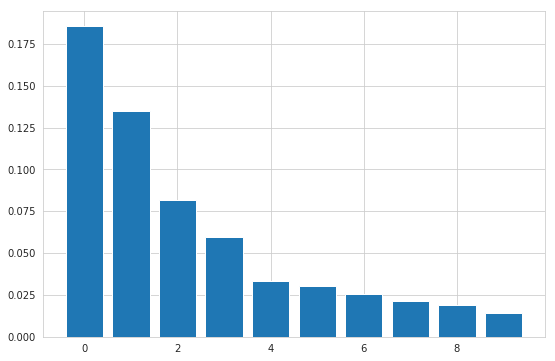

In [63]:
plt.bar(np.arange(10), pca.explained_variance_ratio_)

In [64]:
pca_d1 = x[0,:]
pca_d1.shape

(444135,)

In [65]:
pca_d1_top10, pca_d1_bottom_10 =  pca_d1.argsort()[::-1][:10], pca_d1.argsort()[:10]

In [66]:
print(pca_d1_top10, pca_d1_bottom_10)
print('')
print(pca_d1[pca_d1_top10], pca_d1[pca_d1_bottom_10])

[338530 102499 299353 364737   1156 306150 115951 342422  49424 367931] [ 63604 352187 333345  14972 347588 224953 144618  15405  53181 129222]

[0.005227 0.005158 0.004942 0.004927 0.004884 0.004857 0.004809 0.004775 0.004713 0.004706] [-0.004917 -0.004752 -0.004685 -0.00467  -0.004668 -0.004648 -0.004644 -0.004609 -0.004588 -0.004567]


In [67]:
final_df.iloc[pca_d1_top10].AnswerText

338530    I would like to highlight Pat Hochstein for playing a major role in our department by contributi...
102499    I had occasion to call upon Occupational Health & Hygiene this year to assist with an employee's...
299353    Having been assisted by Ms. Valladolid several times, I have always been impressed by her knowle...
364737    The communications team has advanced the online presence of the university by miles and miles. I...
1156      Vanessa Gonzalez (Pediatrics Department) is an amazing colleague who works very hard to keep our...
306150    Beverly Huizar, Olga Santillan, Hilary Wolf  These ladies do an exceptional job providing outsta...
115951    I feel that Mariko Cavey (Human Development Program) and Christina Knerr Frink (Linguistics) hav...
342422    The custodial service team responds to special situations during their work day with professiona...
49424     Pamela Fruge has been a mentor since I started my position as both the MSO of Education Studies ...
367931    

In [68]:
final_df.iloc[pca_d1_bottom_10].AnswerText

63604     I have always had direct communication to our Financial Aid IT staff.  With them not being readi...
352187                          can't check badminton court reservation status online is really inconvenient.
333345                                                 The online system to place orders is very frustrating.
14972                                                          Markeptplace iRequest is still very confusing.
347588    Personally feel that, with all of the issues experienced with processing payroll through Workday...
224953                                                                      Wifi here is absolutely terrible.
144618                                                                Wireless Network is very very very bad.
15405                                                         The BFS changeover has been somewhat confusing.
53181                                                  The wireless connection in Sixth College is very poor.
129222    

## Word Count derived themes

Using CountVectorizer and TFIDF to look at unigrams, bigrams, and trigrams.  Could be useful to infer themes across for all verbatims, for a given client, for a given survey type, and/or for a given question, etc...

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_token_counts(df, ngrams=1):
    cnt_vec = CountVectorizer(strip_accents='unicode', 
                              stop_words='english', 
                              ngram_range=(ngrams,ngrams), min_df=1)
    
    dtm = cnt_vec.fit_transform(df[pd.notnull(df.AnswerText_Cleaned_Lemmatized)].AnswerText_Cleaned)
     
    sdf = pd.SparseDataFrame(dtm, columns=cnt_vec.get_feature_names(), 
                             dtype=np.int64, default_fill_value=0)
    
    token_count_df = sdf.sum().to_frame('count').copy()
    token_count_df.index.name = 'token'
    token_count_df['ngrams'] = ngrams
    
    return token_count_df.reset_index(), sdf

In [ ]:
# returns a tuple (the filtered df, the token counts for ea gram, and the
# document-term-matrices (DTMs) for each gram)
def get_count_based_themes(benchmark_surveytype=None, 
                           survey_id=None, 
                           question_ans_id=None, 
                           question_text=None,
                           max_ngrams=3, n_top=10):

    # filter df based on args
    df = (
        final_df
            .loc[(survey_id is None) | (final_df.SurveyID == survey_id)]
            .loc[(question_ans_id is None) | (final_df.QuestionAnsID == question_ans_id)]
            .loc[(benchmark_surveytype is None) | 
                 (final_df.BenchmarkSurveyType.str.startswith(str(benchmark_surveytype), na=False))]
            .loc[(question_text is None) | 
                 (final_df.QuestionText.str.contains(str(question_text), na=False))]
    )

    tok_count_df = pd.DataFrame(columns=['token', 'count', 'ngrams'])
    dtm_dfs = []
    
    for i in range(max_ngrams):
        ngram = i+1
        ngram_tok_count_df, dtm_df = get_token_counts(df, ngram)
        
        tok_count_df = tok_count_df.append(
            ngram_tok_count_df.sort_values(by='count', ascending=False)[:n_top], ignore_index=True)
        
        dtm_dfs.append({'ngrams': ngram, 'dtm_df': dtm_df})
        
    return df, tok_count_df, dtm_dfs

In [ ]:
final_df.BenchmarkSurveyType.value_counts()

In [ ]:
filtered_clean_df, tok_count_df, dtm_dfs = get_count_based_themes(benchmark_surveytype='CSS', 
                                                                  survey_id = 144,
                                                                  question_text = 'improve',
                                                                  max_ngrams=4)

len(filtered_clean_df), len(tok_count_df), len(dtm_dfs)

In [ ]:
qans_ids = (final_df
    .loc[final_df.SurveyID == 144]
    .loc[final_df.QuestionText.str.contains('improve', na=False)]
    .QuestionAnsID.value_counts().index.tolist())

In [ ]:
dept_tok_count_df = pd.DataFrame(columns=['token', 'count', 'ngrams', 'dept', 'question_text'])

for i in qans_ids:
    filtered_clean_df, tok_count_df, dtm_dfs = get_count_based_themes(survey_id = 144,
                                                                      question_ans_id = i,
                                                                      max_ngrams=3)
    dept = filtered_clean_df.iloc[0].QuestionCategoryAbbr
    qtext = filtered_clean_df.iloc[0].QuestionText
    tok_count_df['dept'] = dept
    tok_count_df['question_text'] = qtext
    
    dept_tok_count_df = dept_tok_count_df.append(tok_count_df, ignore_index=True)

This is an example about how to cross-reference the actual verbatims for a given word in a specific DTM.

In [ ]:
dtm_dfs[0]['dtm_df']

In [ ]:
# get the DTM built off of unigrams
unigram_dtm_df = dtm_dfs[0]['dtm_df']
len(unigram_dtm_df)

In [ ]:
# get the indexes for where the word "work" was found in the DTM
indexes = list(unigram_dtm_df[unigram_dtm_df['buildings'] >= 1].index)
len(indexes)

In [ ]:
# use the filtered df to display the indexes where the word "work" was found
filtered_clean_df.iloc[indexes].AnswerText.head(10)

In [ ]:
final_df.iloc[329419].AnswerText

## Clustering by department (CSS) or group (S@W)

In [224]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [225]:
vecs = concat_doc_vecs #doc_vecs 
vecs.shape, len(final_df)

((444135, 1200), 444135)

In [226]:
# add vectors to DataFrame
df = final_df.copy() 
df['doc_vector'] = None
df['doc_vector'] = vecs.tolist()

df.head(2)

,Id,SurveyID,QuestionAnsID,RspID,QuestionCategoryID,GroupID,AnswerText,AnswerText_NonEnglish,Language,SurveyTypeID,BenchmarkSurveyType,ClientId,QuestionReportAbbr,QuestionClass,QuestionText,QuestionCategoryAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupName,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,OverallSentiment,IsVeryPositive,IsPositive,IsVeryNegative,IsNegative,IsSuggestion,FeelsThreatened,HasProfanity,IsNonsense,TagCount,LastTaggedOn,labels,prob_IsVeryPositive,prob_IsPositive,prob_IsVeryNegative,prob_IsNegative,prob_IsSuggestion,prob_FeelsThreatened,prob_HasProfanity,prob_IsNonsense,pred_IsVeryPositive,pred_IsPositive,pred_IsVeryNegative,pred_IsNegative,pred_IsSuggestion,pred_FeelsThreatened,pred_HasProfanity,pred_IsNonsense,threshold_f05,threshold_f1,threshold_f2,doc_vector
0,9,115,1877,34968,NaN,1890,"The biggest problem with my office is that the director and management positions are secretive, ...",NaN,English,9,SAW,UCSD,Additional Comments,None,Please provide any additional feedback regarding the work environment at UC San Diego. Your com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.004085,0.021811,0.572653,0.977242,0.025068,0.620683,0.007176,0.000232,0,0,1,1,0,1,0,0,0.29,0.28,0.14,"[-0.024407988414168358, 0.007260238751769066, 0.00017472155741415918, -0.0006572951679117978, 9...."
1,10,115,1877,35000,NaN,1893,There are not enough advancement opportunities for MSP level personnel. There exist no structur...,NaN,English,9,SAW,UCSD,Additional Comments,None,Please provide any additional feedback regarding the work environment at UC San Diego. Your com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.000633,0.020610,0.018632,0.937055,0.236660,0.143600,0.000013,0.001554,0,0,0,1,0,0,0,0,0.29,0.28,0.14,"[-0.019768530502915382, 0.003138097235932946, 0.0018363832496106625, -0.0017876098863780499, 0.0..."


In [227]:
# df.iloc[0]['doc_vector'], vecs[0]

In [228]:
# Filter DataFrame
df_filtered = df[df.SurveyID == 199].copy().reset_index(drop=True)
df_filtered.head(2)

,Id,SurveyID,QuestionAnsID,RspID,QuestionCategoryID,GroupID,AnswerText,AnswerText_NonEnglish,Language,SurveyTypeID,BenchmarkSurveyType,ClientId,QuestionReportAbbr,QuestionClass,QuestionText,QuestionCategoryAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupName,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,OverallSentiment,IsVeryPositive,IsPositive,IsVeryNegative,IsNegative,IsSuggestion,FeelsThreatened,HasProfanity,IsNonsense,TagCount,LastTaggedOn,labels,prob_IsVeryPositive,prob_IsPositive,prob_IsVeryNegative,prob_IsNegative,prob_IsSuggestion,prob_FeelsThreatened,prob_HasProfanity,prob_IsNonsense,pred_IsVeryPositive,pred_IsPositive,pred_IsVeryNegative,pred_IsNegative,pred_IsSuggestion,pred_FeelsThreatened,pred_HasProfanity,pred_IsNonsense,threshold_f05,threshold_f1,threshold_f2,doc_vector
0,424934,199,27977,384580,361.0,-1,"Unfortunately, I don't find the academic coaching helpful. Even though the issues are outlined ...",NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.000852,0.190996,0.028945,0.708579,0.050113,0.000900,0.001065,0.029044,0,0,0,1,0,0,0,0,0.29,0.28,0.14,"[-0.023184537887573242, 0.003676343709230423, 0.0014154794625937939, -0.0037151856813579798, 0.0..."
1,424936,199,27977,384822,361.0,-1,Its apparent that theyre understaffed.,NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,NaN,0.000254,0.054518,0.033582,0.857174,0.006592,0.000509,0.000507,0.033611,0,0,0,1,0,0,0,0,0.29,0.28,0.14,"[-0.03287908062338829, 0.00359342060983181, 0.0008299615583382547, -0.0014927068259567022, 0.003..."


In [229]:
# get filtered vecs
filtered_vecs = np.array(list(df_filtered.doc_vector.values))

filtered_vecs.shape, df_filtered.shape

((21360, 1200), (21360, 71))

In [230]:
unique_qsts = df_filtered.QuestionAnsID.unique()
unique_depts = df_filtered.QuestionCategoryID.unique()

len(unique_qsts), len(unique_depts)

(136, 49)

In [231]:
q_df = df_filtered[df_filtered.QuestionAnsID == 79901].copy().reset_index(drop=True)
q_vecs = np.array(list(q_df.doc_vector.values))

q_df.shape, q_vecs.shape

((933, 71), (933, 1200))

### Using PCA

In [237]:
pca = PCA(10)
q_pca_vecs = pca.fit_transform(q_vecs)

In [238]:
q_pca_vecs.shape, pca.components_.shape, np.sum(pca.explained_variance_ratio_)

((933, 10), (10, 1200), 0.5809631918792639)

<BarContainer object of 10 artists>

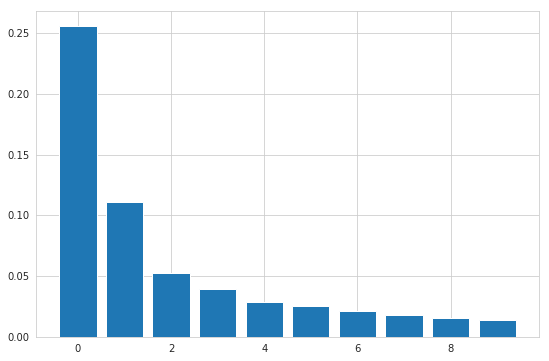

In [239]:
plt.bar(np.arange(pca.n_components_), pca.explained_variance_ratio_)

In [240]:
pcs= q_pca_vecs.T
pcs.shape

(10, 933)

In [241]:
for idx, pc in enumerate(pcs):
    print(f'PC: {idx+1}\n')
    
    top_idxs, bottom_idxs = pc.argsort()[::-1][:10], pc.argsort()[:10]
    print(f'top idxs: {top_idxs[:10]}')
    print(f'bottom idxs: {bottom_idxs[:10]}\n')
    
    print('top verbatims\n------------')
    [ print(ans + '\n') for ans in list(q_df.iloc[top_idxs].AnswerText.values) ]
    
    print('bottom verbatims\n------------')
    [ print(ans + '\n') for ans in list(q_df.iloc[bottom_idxs].AnswerText.values) ]

PC: 1

top idxs: [279  69 205 372 539 386 494 487  88 163]
bottom idxs: [868 293 896 910 103 869 913 295 898 907]

top verbatims
------------
W46 - I have expressed concerns abt the changes being made - specifically that W46, as I understand, is now a lot that can be assigned as an overflow lot. Given the restricted number of spaces available now, this seems an undue burden on those of us who park in it as a primary lot, particularly given my second point: W45 is no longer available as an overflow lot for W46. We are told that we can use lots very far away as overflow lots, when there is a whole 2nd garage available right next to the first one. First, this is a waste of my valuable work time - why should I have to walk from a far overflow location, when a second garage is available right here? I pay a lot of money to park close to where I work. And no, this is not a choice. I have a family situation that requires, for now, that I have a car available at a moment's notice. I can't park 

### Using t-SNE

In [242]:
tsne = TSNE(n_components=10, method='exact')
q_tsne_vecs = tsne.fit_transform(q_vecs)

q_tsne_vecs.shape

(933, 10)

In [243]:
pcs= q_tsne_vecs.T
pcs.shape

for idx, pc in enumerate(pcs):
    print(f'PC: {idx+1}\n')
    
    top_idxs, bottom_idxs = pc.argsort()[::-1][:10], pc.argsort()[:10]
    print(f'top idxs: {top_idxs[:10]}')
    print(f'bottom idxs: {bottom_idxs[:10]}\n')
    
    print('top verbatims\n------------')
    [ print(ans + '\n') for ans in list(q_df.iloc[top_idxs].AnswerText.values) ]
    
    print('bottom verbatims\n------------')
    [ print(ans + '\n') for ans in list(q_df.iloc[bottom_idxs].AnswerText.values) ]

PC: 1

top idxs: [521  64 390 693 154 701 208 682 239 696]
bottom idxs: [212 133  52 738 891 876  99  43 865 606]

top verbatims
------------
The new system where guests provide a number is less easy for guests than the previous system. We have also had issues where we were told there would not be enough parking for our event but in reality, there were many spots available.

The parking situation is awful.  Meters on the street dont even Allow you enough time to get through a two hour class and the parking pass options are vastly insufficient for the number of students trying to buy them for what is primarily a commuter campus.

Its terrible in every way decribable

We need more parking pay stations in the Padelford Garage. I have been up to 20 min late to my 6p class trying to pay for evening parking.

I am working professional.  I had to plan out to get a parking permit every quarter.  Any possible option of renewing on either weekend or online?

The people in the central plaza gateh

## Clustering via test dataset

In [69]:
test_df = pd.read_csv(CLS_PATH/f'all_predictions_20190522.csv', dtype=dtypes, parse_dates=date_cols)

# prepare dataset
test_df = pd.read_csv(f'../data/clean/{verbatims_filename}', dtype=dtypes, parse_dates=date_cols)
test_df_filtered = test_df[test_df.SurveyID == 199].copy()
test_df_filtered.reset_index(drop=True, inplace=True)

test_df_filtered['labels'] = ''

In [70]:
test_data = (TextList
             .from_df(test_df_filtered, cols=['AnswerText'], processor=learn.data.processor)
             .split_none()
             .label_from_df(cols='labels', classes=LABELS_SENT[1:], label_delim=' ')
#              .process()
            )

In [71]:
# build a DataLoader => fastai.basic_data.DeviceDataLoader
test_dl = DeviceDataLoader.create(test_data.train, bs=80, shuffle=False, collate_fn=pad_collate, device=device)

In [72]:
learn = None; gc.collect()
learn = load_learner(CLS_PATH, file='export_clas.pkl').load('fwd_cls_bestmodel_multilabel')
learn.model = learn.model.to(device)
learn.model = learn.model.eval()

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiLabelClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [73]:
%%time

test_probs, doc_vecs, concat_doc_vecs = [], [], []

with torch.no_grad():
    for i,b in enumerate(iter(test_dl)):
        if i % 1000 == 0: print(i)
            
        # reset hidden state (if you don't do this you will OOM)
        learn.model.reset()
        
        probs, raw_outputs, outputs = to_detach(learn.model(b[0]))
        test_probs.append(probs)
        doc_vecs.append(raw_outputs[-1][:,-1,:])
        concat_doc_vecs.append(concat_pool(raw_outputs))
        
all_probs = torch.cat(test_probs)
all_vecs = torch.cat(doc_vecs)
all_concat_vecs = torch.cat(concat_doc_vecs)

0
CPU times: user 6min 23s, sys: 32.7 s, total: 6min 56s
Wall time: 1min 11s


In [74]:
all_probs.shape, all_vecs.shape, all_concat_vecs.shape

(torch.Size([21360, 8]), torch.Size([21360, 400]), torch.Size([21360, 1200]))

In [75]:
test_df_filtered.head()

,Id,SurveyID,QuestionAnsID,RspID,QuestionCategoryID,GroupID,AnswerText,AnswerText_NonEnglish,Language,SurveyTypeID,BenchmarkSurveyType,ClientId,QuestionReportAbbr,QuestionClass,QuestionText,QuestionCategoryAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupName,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,OverallSentiment,IsVeryPositive,IsPositive,IsVeryNegative,IsNegative,IsSuggestion,FeelsThreatened,HasProfanity,IsNonsense,TagCount,LastTaggedOn,labels
0,424934,199,27977,384580,361.0,-1,"Unfortunately, I don't find the academic coaching helpful. Even though the issues are outlined ...",NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,
1,424936,199,27977,384822,361.0,-1,Its apparent that theyre understaffed.,NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,
2,424941,199,27977,385064,361.0,-1,They don't have a lot of power over anything in the University. The little they're allowed to do...,NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,
3,424943,199,27977,385404,361.0,-1,"I felt largely confused by the office, was misled several times, treated extremely rudely, and o...",NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,
4,424945,199,27977,385698,361.0,-1,Testing center staff is always really helpful and respectful.,NaN,English,24,CSS,UW,HousingDisabilities_Experience,Verbatim-Dept-Question,Is there anything else we should know about your experience with Disability Resources for Students?,Acad Housing Students w Disabilities,Academic & Housing Accommodations for Students with Disabilities,Student,Student Life,Student Activities,1,-1.0,None,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,NaT,


In [76]:
to_np(all_probs[:5])

array([[6.145311e-04, 1.804924e-01, 2.623472e-02, 7.295148e-01, 4.416472e-02, 7.668567e-04, 8.197485e-04,
        2.655916e-02],
       [2.850520e-04, 7.916389e-02, 1.990854e-02, 7.931570e-01, 7.734378e-03, 5.966546e-04, 4.138617e-04,
        5.213697e-02],
       [8.186911e-05, 8.098610e-02, 5.137621e-02, 9.363937e-01, 1.378011e-02, 1.404198e-03, 2.203869e-03,
        3.653332e-03],
       [5.775928e-04, 2.478627e-03, 3.887125e-01, 9.938024e-01, 2.150196e-03, 5.250870e-01, 2.070175e-04,
        1.647093e-03],
       [6.098409e-01, 9.776468e-01, 9.124706e-03, 4.855023e-03, 1.970284e-03, 3.619016e-03, 4.822638e-03,
        2.852986e-02]], dtype=float32)